In [1]:
# Importación de todas lsa librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Conversión de euro a dolar, para poder ofrecerle al cliente los datos en su moneda

euro_to_usd = 1.10

In [3]:
# Carga de datos

complete_with_cars = pd.read_csv("..\Datasets\complete_with_cars.csv")

In [4]:
complete_with_cars.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75475 entries, 0 to 75474
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tpep_pickup_datetime   75475 non-null  object 
 1   tpep_dropoff_datetime  75475 non-null  object 
 2   passenger_count        75475 non-null  float64
 3   trip_distance          75475 non-null  float64
 4   RatecodeID             75475 non-null  float64
 5   PULocationID           75475 non-null  object 
 6   DOLocationID           75475 non-null  int64  
 7   payment_type           75475 non-null  int64  
 8   fare_amount            75475 non-null  float64
 9   total_amount           75475 non-null  float64
 10  LocationID             75475 non-null  int64  
 11  Borough                73235 non-null  object 
 12  Zone                   75330 non-null  object 
 13  service_zone           73090 non-null  object 
 14  placa                  75475 non-null  object 
 15  Br

In [5]:
complete_with_cars.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,...,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,2024-06-01 00:34:43,2024-06-01 00:44:45,3.0,4.89,1.0,la guardia,192,2,19.8,29.05,...,420,183,560,Yes,RWD,Type 2 CCS,SUV,C,5,40000
1,2024-06-01 00:17:58,2024-06-01 00:46:05,2.0,11.10,1.0,la guardia,230,3,47.8,66.49,...,255,176,390,Yes,FWD,Type 2 CCS,SUV,B,5,35000
2,2024-06-01 00:58:15,2024-06-01 01:39:37,2.0,17.13,2.0,jfk,48,1,70.0,98.88,...,400,160,380,Yes,FWD,Type 2 CCS,SUV,B,5,40795
3,2024-06-01 00:05:17,2024-06-01 00:57:22,2.0,18.18,2.0,jfk,100,1,70.0,92.69,...,230,165,260,Yes,RWD,Type 2 CCS,Hatchback,B,4,41526
4,2024-06-01 00:10:00,2024-06-01 00:35:56,2.0,9.45,1.0,la guardia,100,1,41.5,74.80,...,320,181,440,Yes,RWD,Type 2 CCS,SUV,C,5,37500


In [6]:
print(complete_with_cars.isnull().sum())

tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count             0
trip_distance               0
RatecodeID                  0
PULocationID                0
DOLocationID                0
payment_type                0
fare_amount                 0
total_amount                0
LocationID                  0
Borough                  2240
Zone                      145
service_zone             2385
placa                       0
Brand                       0
Model                       0
AccelSec                    0
TopSpeed_KmH                0
Range_Km                    0
Efficiency_WhKm             0
FastCharge_KmH              0
RapidCharge                 0
PowerTrain                  0
PlugType                    0
BodyStyle                   0
Segment                     0
Seats                       0
PriceEuro                   0
dtype: int64


En la columna no hay datos nulos, por lo que no se va a necesitar hacer limpieza ni reemplazo de los mismos.

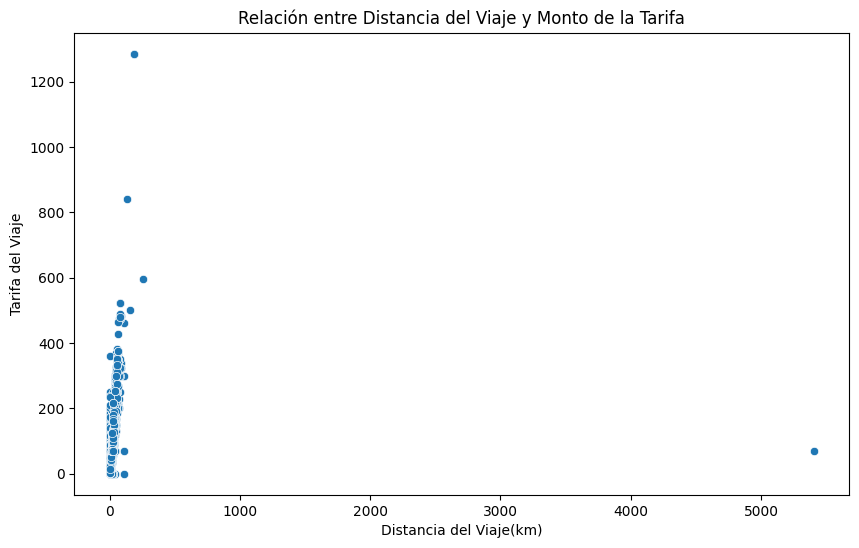

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=complete_with_cars)
plt.xlabel('Distancia del Viaje(km)')
plt.ylabel('Tarifa del Viaje')
plt.title('Relación entre Distancia del Viaje y Monto de la Tarifa')
plt.show()


Hay una relación bastante estable entre la distancia del viaje y su tarifa, aunque se observan valores atípicos, pero en una muy pequeña proporción.

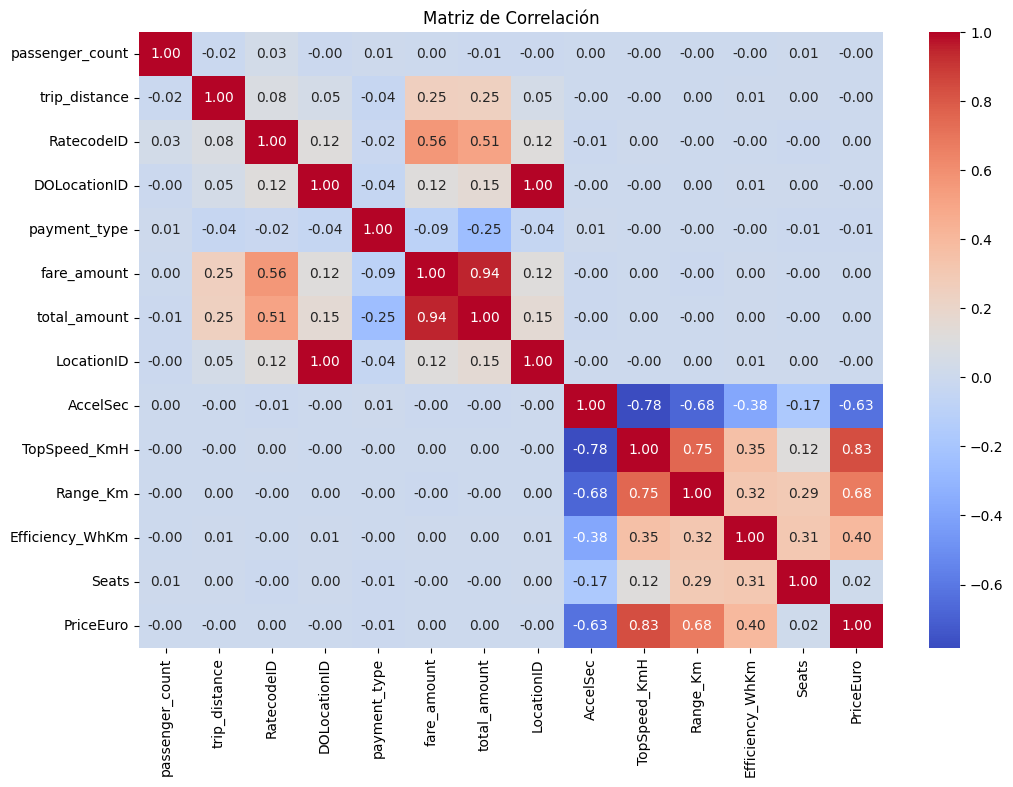

In [8]:
# Matriz de correlación
df_numeric = complete_with_cars.select_dtypes(include=['float64', 'int64'])
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


Se puede observar que hay una relación más fuerte entre la eficiencia energética de los vehículos y el costo del mismo y de su mantenimiento mensual.

También, como es de esperar, hay una gran relación entre la distancia recorrida y la energía consumida y el costo del viaje.

Estas muestras de las relaciones entre los distintos datos van a ser fundamentales a la hora de desarrollar el modelo del ROI.

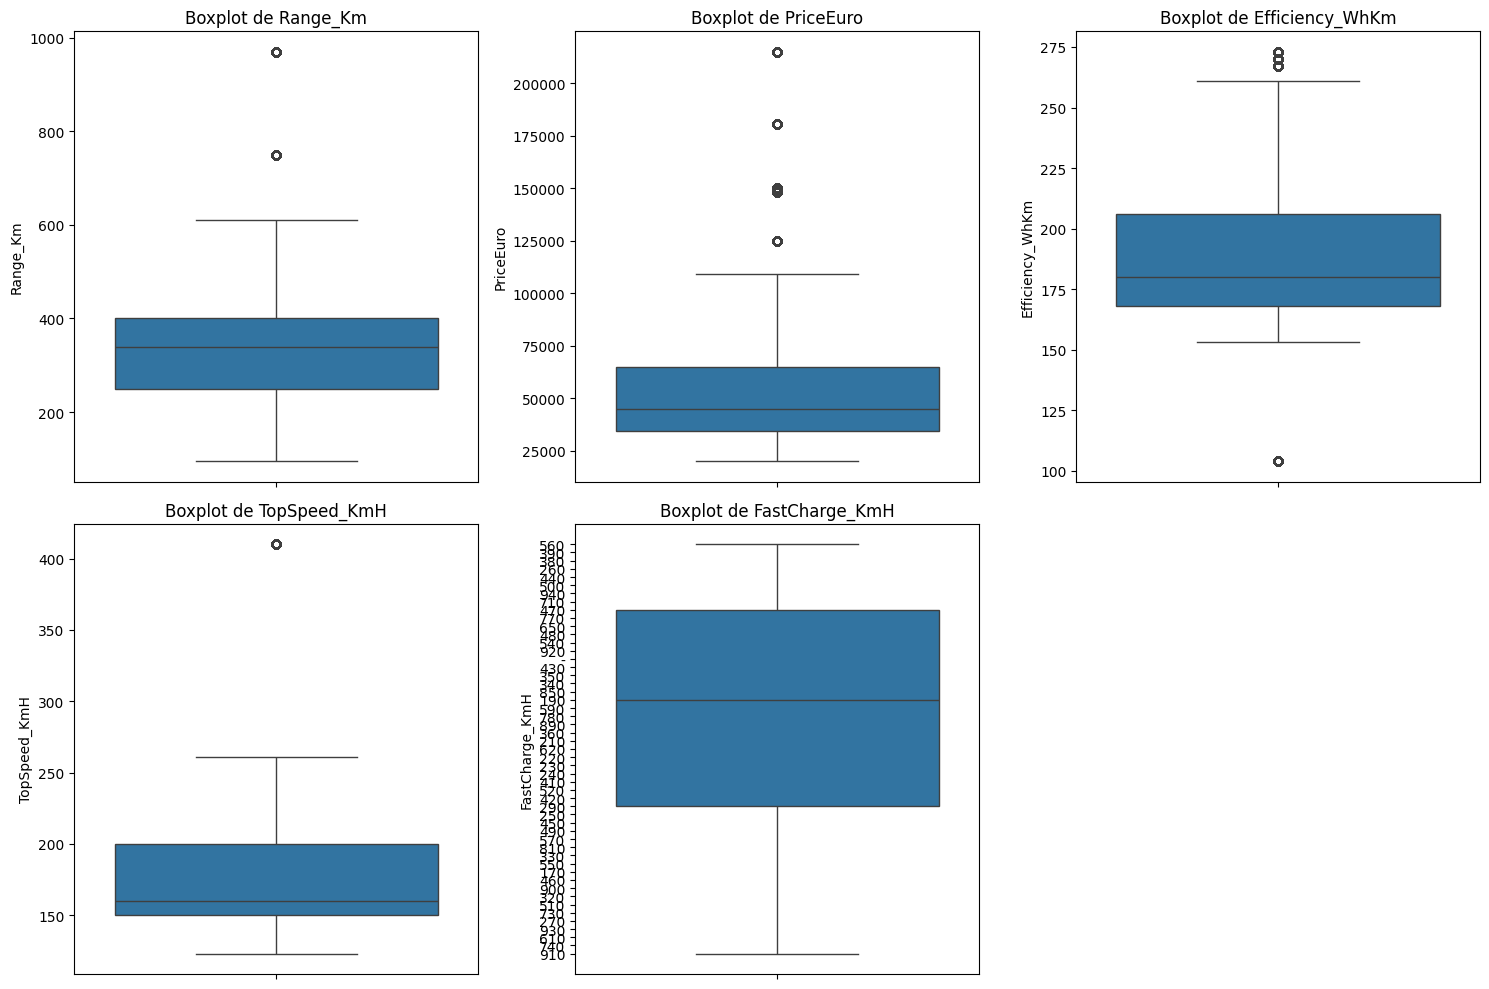

In [9]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(['Range_Km', 'PriceEuro', 'Efficiency_WhKm', 'TopSpeed_KmH', 'FastCharge_KmH']):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=column, data=complete_with_cars)
    plt.title(f'Boxplot de {column}')
plt.tight_layout()
plt.show()


Las columnas de los features, a excepción de el precio en euros, contienen muy pocos outliers. Estos no afectan a la eficiencia del modelo, por lo que no es de mayor importancia eliminarlos o reemplazarlos.

In [10]:
# Eliminar vehículos duplicados por 'Brand', 'Model' y 'Range_Km'
complete_with_cars = complete_with_cars.drop_duplicates(subset=['Brand', 'Model', 'Range_Km'])

# Convertir la distancia de millas a kilómetros
complete_with_cars['trip_distance_km'] = complete_with_cars['trip_distance'] * 1.60934

# Crear una columna para la eficiencia (consumo energético) en Wh/km
complete_with_cars['energy_consumed_kwh'] = (complete_with_cars['trip_distance_km'] * complete_with_cars['Efficiency_WhKm']) / 1000

# Asignar un costo promedio por kWh en USD
electricity_cost_per_kwh = 0.13 * euro_to_usd  # Convertir a dólares

# Calcular el costo mensual de carga eléctrica (suponiendo 2000 km recorridos al mes)
average_km_per_month = 2000
complete_with_cars['monthly_charge_cost'] = (average_km_per_month * complete_with_cars['Efficiency_WhKm'] / 1000) * electricity_cost_per_kwh

# Crear columnas de ingresos y costos mensuales en USD
complete_with_cars['monthly_revenue'] = 3000 * euro_to_usd  # Ingresos mensuales estimados (convertidos a dólares)
complete_with_cars['total_monthly_cost'] = complete_with_cars['monthly_charge_cost'] + 500 * euro_to_usd  # Costos operativos estimados (en dólares)

# Calcular la ganancia neta mensual
complete_with_cars['net_monthly_profit'] = complete_with_cars['monthly_revenue'] - complete_with_cars['total_monthly_cost']

# Limpiar los valores no numéricos
complete_with_cars.replace('-', np.nan, inplace=True)

# Verificar y eliminar valores faltantes en las columnas predictoras
complete_with_cars.dropna(subset=['Range_Km', 'PriceEuro', 'Efficiency_WhKm', 'Seats', 'TopSpeed_KmH', 'FastCharge_KmH', 'PowerTrain'], inplace=True)

# Convertir la columna 'PowerTrain' a variables dummy
complete_with_cars = pd.get_dummies(complete_with_cars, columns=['PowerTrain'], drop_first=True)

In [11]:
# Definir las variables predictoras (features) y la variable objetivo (target)
X = complete_with_cars[['Range_Km', 'PriceEuro', 'Efficiency_WhKm', 'Seats', 'TopSpeed_KmH', 'FastCharge_KmH'] + [col for col in complete_with_cars.columns if 'PowerTrain_' in col]]
y = complete_with_cars['net_monthly_profit']  # Nuestro target será la ganancia neta mensual

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Crear y entrenar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Crear y entrenar un modelo RandomForestRegressor como alternativa
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluar el modelo
linear_model_score = linear_model.score(X_test, y_test)
rf_model_score = rf_model.score(X_test, y_test)

In [13]:
# Resultados de la evaluación
print(f"Puntuación del modelo de regresión lineal: {linear_model_score:.2f}")
print(f"Puntuación del modelo Random Forest: {rf_model_score:.2f}")

# Interpretación de los resultados
if linear_model_score > rf_model_score:
    print("El modelo de regresión lineal tiene un mejor desempeño.")
elif rf_model_score > linear_model_score:
    print("El modelo Random Forest tiene un mejor desempeño.")
else:
    print("Ambos modelos tienen el mismo desempeño.")


Puntuación del modelo de regresión lineal: 1.00
Puntuación del modelo Random Forest: 0.99
El modelo de regresión lineal tiene un mejor desempeño.


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Realizar validación cruzada para el modelo de regresión lineal
linear_scores = cross_val_score(linear_model, X, y, cv=5, scoring='r2')  # cv=5 para 5 folds

# Realizar validación cruzada para el modelo Random Forest
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')


In [15]:
print(f"Puntuación media del modelo de regresión lineal: {linear_scores.mean():.2f} ± {linear_scores.std():.2f}")
print(f"Puntuación media del modelo Random Forest: {rf_scores.mean():.2f} ± {rf_scores.std():.2f}")

# Comparar los modelos
if linear_scores.mean() > rf_scores.mean():
    print("El modelo de regresión lineal tiene un mejor desempeño en validación cruzada.")
elif rf_scores.mean() > linear_scores.mean():
    print("El modelo Random Forest tiene un mejor desempeño en validación cruzada.")
else:
    print("Ambos modelos tienen un desempeño similar en validación cruzada.")


Puntuación media del modelo de regresión lineal: 1.00 ± 0.00
Puntuación media del modelo Random Forest: 0.95 ± 0.08
El modelo de regresión lineal tiene un mejor desempeño en validación cruzada.


A modo de conclusión, se puede observar que el modelo, a pesar de contener muchos datos, es muy preciso. Para esto se trabajó con dos modelos distintos y se adapta bien a los dos, siendo el más preciso el de regresión lineal, por tener mayor relación entre las diferentes columnas.